In [1]:
import seaborn as sns
from alphaanalysis.plot.gam import get_sig_intervals
from matplotlib import pyplot as plt

# Data Base

In [ ]:
from IPython.display import clear_output

from djimaging.user.alpha.schemas.alpha_schema import *
from djimaging.user.alpha.utils import database

indicator = 'calcium'
database.connect_dj(indicator=indicator)
clear_output()

# Data

In [ ]:
rf_kind = 'roi'

if rf_kind == 'field':
    rf_tab = (database.get_rf_tab(quality_filter=True, roi_kind='field').proj(rf_size='rf_cdia_um', surround_index='full_surround_index', tri='transience_idx') * 
              FieldRoiPosMetrics.proj(soma_dist='d_dist_to_soma') * 
              RetinalFieldLocationWing().proj(group="wing_side"))
    df = rf_tab.fetch(format='frame').reset_index()
else:  
    rf_tab = (database.get_rf_tab(quality_filter=True, roi_kind='roi').proj(rf_size='rf_cdia_um', surround_index='full_surround_index', tri='transience_idx') * 
              FieldPosMetrics.RoiPosMetrics.proj(soma_dist='d_dist_to_soma') * 
              RetinalFieldLocationWing().proj(group="wing_side"))
    df = rf_tab.fetch(format='frame').reset_index()

df

In [4]:
import utils

df = utils.prep_df(df)
df.head()

,experimenter,date,exp_num,field,stim_name,cond1,roi_id,tri,rf_size,surround_index,soma_dist,group,cell_id,field_id
0,Ran,2018-06-10,1,D1,noise_2500,control,1,0.832512,140.676,-0.121651,140.978,d,2018-06-10_1,2018-06-10_1_D1
1,Ran,2018-06-10,1,D1,noise_2500,control,2,0.837954,151.144,-0.193695,112.357,d,2018-06-10_1,2018-06-10_1_D1
2,Ran,2018-06-10,1,D1,noise_2500,control,4,0.841921,133.757,-0.083276,137.378,d,2018-06-10_1,2018-06-10_1_D1
3,Ran,2018-06-10,1,D1,noise_2500,control,5,0.870017,140.853,-0.104874,124.131,d,2018-06-10_1,2018-06-10_1_D1
4,Ran,2018-06-10,1,D1,noise_2500,control,6,0.740679,142.584,-0.069049,120.920,d,2018-06-10_1,2018-06-10_1_D1


# Plot

In [5]:
from alphaanalysis import plot as plota
plota.set_rc_params()

In [6]:
order = plota.get_order(indicator=indicator)
palette = plota.get_palette(indicator=indicator)
colors = [palette[group] for group in order]

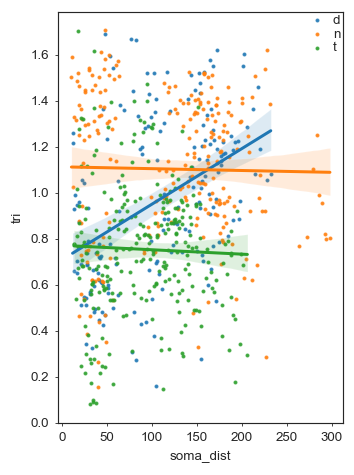

In [7]:
utils.plot_scatter_metrics(df, ['tri'], groupby='group')

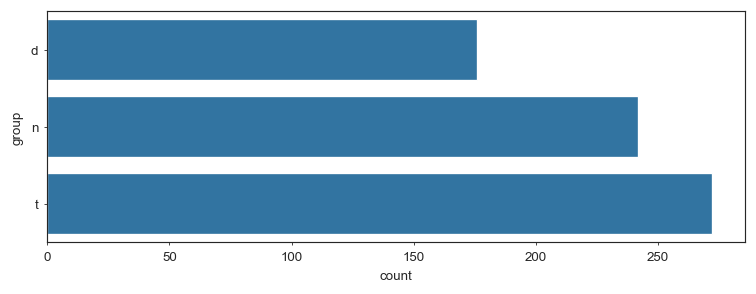

In [8]:
sns.countplot(data=df, y="group");

# Fit GAM

In [9]:
%load_ext rpy2.ipython

In [10]:
%%R
#noqa

rm(list=ls()) 

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


## R imports

In [11]:
%%R
#noqa

library("IRdisplay")
library("dplyr")
library('parallel')
library('ggplot2')
library("nlme")
library("mgcv")
library("ggthemes")
library("itsadug")
library("png")
library("xtable")
library("tidymv")
library("cowplot")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Want to understand how all the pieces fit together? Read R for Data
Science: https://r4ds.had.co.nz/

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

This is mgcv 1.9-0. For overview type 'help("mgcv-package")'.
Loading required package: plotfunctions

Attaching package: ‘plotfunctions’

The following object is masked from ‘package:ggplot2’:

    alpha

Loaded package itsadug 2.4 (see 'help("itsadug")' ).

Attaching package: ‘xtable’

The following object is masked from ‘package:IRdisplay’:

    display

tidymv has been superseded by tidygam. The package tidymv is no longer maintained but will be
    kept on CRAN to ensure reproducibility of older analyses. Users should
    use the replacement package tidygam for new analyses, which is available

# Import R df

In [12]:
%%R -i df

df$group <- factor(df$group)
df$cell_id <- factor(df$cell_id)
df$field_id <- factor(df$field_id)


df <- df[df$soma_dist <= 200, ]

head(df)

  experimenter   date exp_num field  stim_name   cond1 roi_id      tri rf_size
0          Ran 736855       1    D1 noise_2500 control      1 0.832512 140.676
1          Ran 736855       1    D1 noise_2500 control      2 0.837954 151.144
2          Ran 736855       1    D1 noise_2500 control      4 0.841921 133.757
3          Ran 736855       1    D1 noise_2500 control      5 0.870017 140.853
4          Ran 736855       1    D1 noise_2500 control      6 0.740679 142.584
5          Ran 736855       1    D1 noise_2500 control      7 0.936402 136.740
  surround_index soma_dist group      cell_id        field_id
0     -0.1216510   140.978     d 2018-06-10_1 2018-06-10_1_D1
1     -0.1936950   112.357     d 2018-06-10_1 2018-06-10_1_D1
2     -0.0832763   137.378     d 2018-06-10_1 2018-06-10_1_D1
3     -0.1048740   124.131     d 2018-06-10_1 2018-06-10_1_D1
4     -0.0690491   120.920     d 2018-06-10_1 2018-06-10_1_D1
5     -0.0281440   128.833     d 2018-06-10_1 2018-06-10_1_D1


## Helper functions

In [13]:
%%R
#noqa

display_model <- function(m){
    print(summary(m));
    tabs <- capture.output(gamtabs(m, type="HTML"));
    display_html(tabs);
}

## Plot raw data

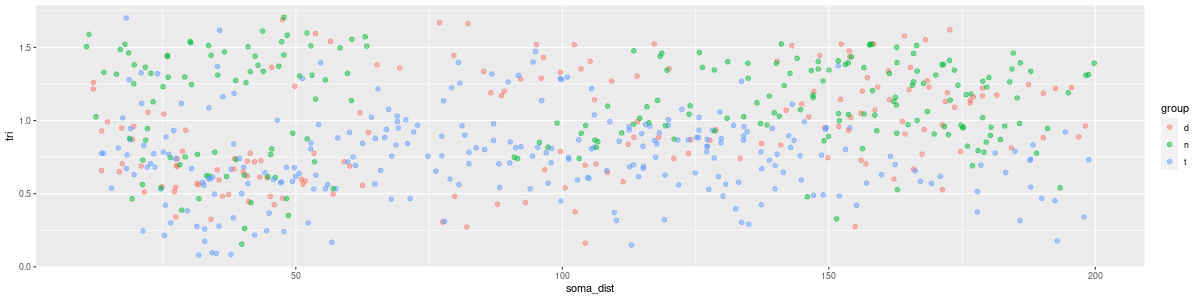

In [14]:
%%R -w 1200 -h 300
#noqa

p1 <- ggplot(aes(x=soma_dist, y=tri, color=group), data=df)  +
    geom_point(alpha=.5, size=2)

p1

# GAMs

## TRi

In [15]:
%%R
#noqa

m1_tri  <- gam(tri ~ group + s(soma_dist, k=8, bs="cr"), data=df)
m2_tri  <- gam(tri ~ group + s(soma_dist, by=group, k=8, bs="cr"), data=df)
m3a_tri <- gam(tri ~ group + s(soma_dist, by=group, k=8, bs="cr") + s(cell_id, bs="re"), data=df)
m3b_tri <- gam(tri ~ group + s(soma_dist, by=group, k=8, bs="cr") + s(cell_id, bs="re"), data=df, family='scat')
m4a_tri <- gam(tri ~ group + s(soma_dist, by=group, k=12, bs="cr") + s(cell_id, bs="re"), data=df)
m4b_tri <- gam(tri ~ group + s(soma_dist, by=group, k=12, bs="cr") + s(cell_id, bs="re"), data=df, family='scat')
m5a_tri <- gam(tri ~ group + s(soma_dist, by=group, k=16, bs="cr") + s(cell_id, bs="re"), data=df)
m5b_tri <- gam(tri ~ group + s(soma_dist, by=group, k=16, bs="cr") + s(cell_id, bs="re"), data=df, family='scat')

In [16]:
%%R
#noqa
BIC(m1_tri, m2_tri, m3a_tri, m3b_tri, m4a_tri, m4b_tri, m5a_tri, m5b_tri)

              df      BIC
m1_tri  10.66565 364.6326
m2_tri  22.59021 401.2657
m3a_tri 35.44732 261.3915
m3b_tri 33.72064 262.8983
m4a_tri 35.23709 256.9904
m4b_tri 37.08006 271.1298
m5a_tri 35.38635 258.7146
m5b_tri 37.57276 275.0347


In [17]:
%%R
#noqa
anova(m1_tri, m2_tri, m3a_tri, m4a_tri, m5a_tri, test="F")

Analysis of Deviance Table

Model 1: tri ~ group + s(soma_dist, k = 8, bs = "cr")
Model 2: tri ~ group + s(soma_dist, by = group, k = 8, bs = "cr")
Model 3: tri ~ group + s(soma_dist, by = group, k = 8, bs = "cr") + s(cell_id, 
    bs = "re")
Model 4: tri ~ group + s(soma_dist, by = group, k = 12, bs = "cr") + s(cell_id, 
    bs = "re")
Model 5: tri ~ group + s(soma_dist, by = group, k = 16, bs = "cr") + s(cell_id, 
    bs = "re")
  Resid. Df Resid. Dev       Df Deviance       F    Pr(>F)    
1    642.04     60.064                                        
2    628.77     56.435 13.27165   3.6295  4.2293 6.886e-07 ***
3    615.09     40.076 13.67570  16.3591 18.4996 < 2.2e-16 ***
4    613.82     39.889  1.27714   0.1863  2.2565    0.1263    
5    613.10     39.936  0.72119  -0.0463                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [18]:
%%R
#noqa
anova(m3b_tri, m4b_tri, m5b_tri, test="F")

Analysis of Deviance Table

Model 1: tri ~ group + s(soma_dist, by = group, k = 8, bs = "cr") + s(cell_id, 
    bs = "re")
Model 2: tri ~ group + s(soma_dist, by = group, k = 12, bs = "cr") + s(cell_id, 
    bs = "re")
Model 3: tri ~ group + s(soma_dist, by = group, k = 16, bs = "cr") + s(cell_id, 
    bs = "re")
  Resid. Df Resid. Dev      Df Deviance Pr(>Chi)  
1    617.27     44.387                            
2    613.02     30.849 4.24658  13.5377  0.01087 *
3    612.20     31.562 0.82258  -0.7122           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



Family: Scaled t(17.62,0.242) 
Link function: identity 

Formula:
tri ~ group + s(soma_dist, by = group, k = 8, bs = "cr") + s(cell_id, 
    bs = "re")

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.84380    0.09889   8.533   <2e-16 ***
groupn       0.19531    0.13390   1.459    0.145    
groupt      -0.11405    0.13311  -0.857    0.392    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                       edf Ref.df Chi.sq  p-value    
s(soma_dist):groupd  2.479  3.100  36.65  < 2e-16 ***
s(soma_dist):groupn  5.229  6.059  24.87 0.000596 ***
s(soma_dist):groupt  4.766  5.629  19.96 0.004968 ** 
s(cell_id)          13.234 14.000 263.60  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.469   Deviance explained = 47.7%
-REML =  83.44  Scale est. = 1         n = 652

Method: REML   Optimizer: outer newton
full convergence after 7 

In addition: Warning message:
In getOption("jupyter.base_display_func")(data, metadata) :
  IRdisplay can only be used from the IPython R kernel and R magic.


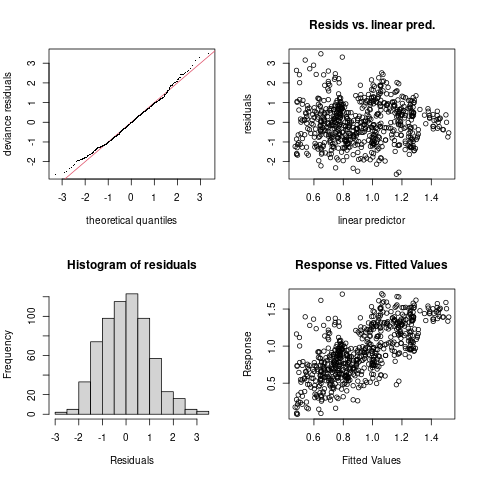

In [19]:
%%R
#noqa

m_rf_tri <- m3b_tri
display_model(m_rf_tri)
gam.check(m_rf_tri)

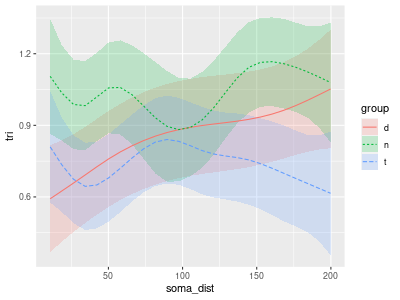

In [20]:
%%R -w 400 -h 300
#noqa

p1 <- plot_smooths(model=m_rf_tri, series=soma_dist, comparison=group)
plot(p1, ylim=c(0, 60))

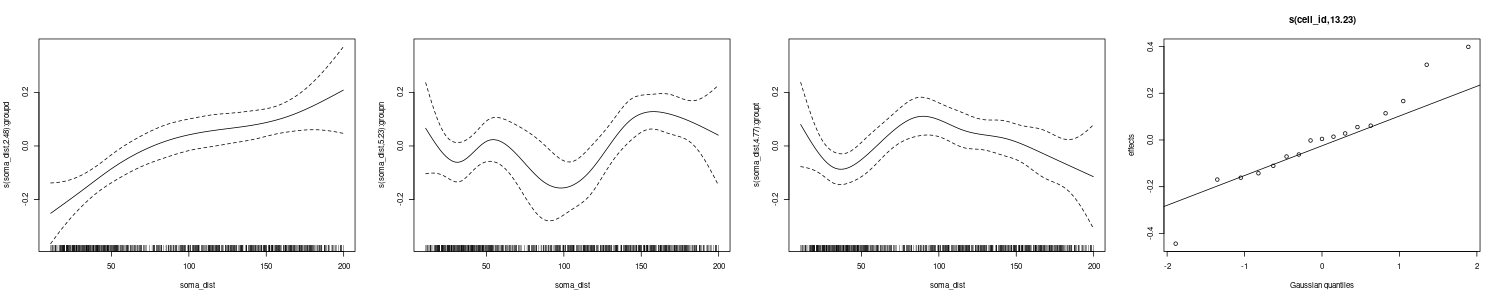

In [21]:
%%R -w 1500 -h 300
#noqa

par(mfrow = c(1,4))
plot(m_rf_tri)

### Plot fits

In [22]:
%%R
#noqa

r_df_pred_tri = predict_gam(m_rf_tri, exclude_terms=s(cell_id, bs="re"))
head(r_df_pred_tri)

# A tibble: 6 × 5
  group soma_dist cell_id        fit se.fit
  <fct>     <dbl> <fct>        <dbl>  <dbl>
1 d          10.7 2018-06-10_1 0.592  0.115
2 n          10.7 2018-06-10_1 1.11   0.123
3 t          10.7 2018-06-10_1 0.810  0.119
4 d          14.6 2018-06-10_1 0.608  0.111
5 n          14.6 2018-06-10_1 1.07   0.111
6 t          14.6 2018-06-10_1 0.772  0.109


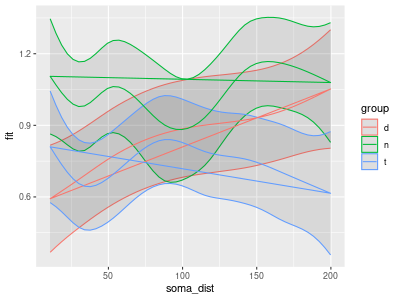

In [23]:
%%R -w 400 -h 300
#noqa

predict_gam(m_rf_tri, exclude_terms=s(cell_id, bs="re")) %>%
    ggplot(aes(soma_dist, fit, col=group)) +
    geom_smooth_ci()

### Plot differences 

[1] 2.39398
Summary:
	* soma_dist : numeric predictor; with 100 values ranging from 10.734400 to 199.793000. 
	* cell_id : factor; set to the value(s): 2020-05-10_1. (Might be canceled as random effect, check below.) 
	* NOTE : The following random effects columns are canceled: s(cell_id)
 

soma_dist window(s) of significant difference(s):
	10.734400 - 24.102180
Summary:
	* soma_dist : numeric predictor; with 100 values ranging from 10.734400 to 199.793000. 
	* cell_id : factor; set to the value(s): 2020-05-10_1. (Might be canceled as random effect, check below.) 
	* NOTE : The following random effects columns are canceled: s(cell_id)
 

soma_dist window(s) of significant difference(s):
	29.831228 - 58.476471
	136.773467 - 199.793000
Summary:
	* soma_dist : numeric predictor; with 100 values ranging from 10.734400 to 199.793000. 
	* cell_id : factor; set to the value(s): 2020-05-10_1. (Might be canceled as random effect, check below.) 
	* NOTE : The following random effects columns ar

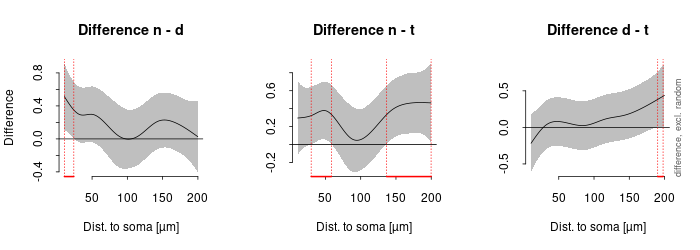

In [24]:
%%R -w 700 -h 250 -o nd_diff_tri -o nt_diff_tri -o dt_diff_tri
#noqa

n_diffs <- 3
par(mfrow=c(1, n_diffs), cex=1.0, tcl=-0.2)

se <- qnorm((100 - (2.5/n_diffs))/100)
print(se)
ylim <- NULL #c(-150, 150)
ylab <- 'Difference'
xlab <- 'Dist. to soma [µm]'

nd_diff_tri <- plot_diff(m_rf_tri, view="soma_dist", comp=list(group=c("n", "d")), se=se, ylab=ylab, xlab=xlab, ylim=ylim, hide.label=TRUE)
nt_diff_tri <- plot_diff(m_rf_tri, view="soma_dist", comp=list(group=c("n", "t")), se=se, ylab='', xlab=xlab, ylim=ylim, hide.label=TRUE)
dt_diff_tri <- plot_diff(m_rf_tri, view="soma_dist", comp=list(group=c("d", "t")), se=se, ylab='', xlab=xlab, ylim=ylim)

In [25]:
pairs_sig_regions_tri = [
    ("n vs. d", get_sig_intervals(nd_diff_tri)),
    ("n vs. t", get_sig_intervals(nt_diff_tri)),
    ("d vs. t", get_sig_intervals(dt_diff_tri)),
]
pairs_sig_regions_tri

[0 7]
[]
[ 9 25 65 99]
[]
[93 98]
[]


[('n vs. d', [(10.7344, 24.1021797979798)]),
 ('n vs. t',
  [(27.921545454545456, 58.47647070707071), (134.86378383838385, 199.793)]),
 ('d vs. t', [(188.33490303030302, 197.88331717171718)])]

# Go back to python for easy plotting

In [26]:
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

with localconverter(ro.default_converter + pandas2ri.converter):
    df_pred_tri = ro.conversion.rpy2py(ro.globalenv['r_df_pred_tri'])

In [27]:
df_pred_tri.head()

,group,soma_dist,cell_id,fit,se.fit
1,d,10.734400,2018-06-10_1,0.592339,0.114528
2,n,10.734400,2018-06-10_1,1.105316,0.123143
3,t,10.734400,2018-06-10_1,0.809873,0.119192
4,d,14.592739,2018-06-10_1,0.608343,0.111102
5,n,14.592739,2018-06-10_1,1.069806,0.110666


(2.5, 2)


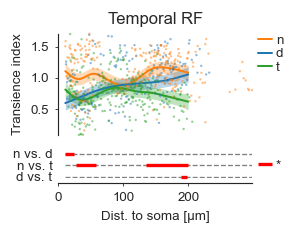

In [28]:
fig, axs = utils.plot_fits(
    df=df,
    df_preds=[df_pred_tri],
    pairs_sig_regions_list=[pairs_sig_regions_tri],
    titles=[None],
    ys=['tri'],
    ylabels=['Transience index'],
    x='soma_dist',
    xlabel='Dist. to soma [µm]',
    order=order, colors=colors,
    figsize=(2.5, 2), ms=2, ma=0.5
)
axs[0].set_title("Temporal RF")
plt.tight_layout()
plt.savefig(f'figures/{indicator}_soma_dist_rf_tri.pdf')
plt.show()